## Predicting a Biological Response (Прогнозирование биологического ответа)

***Цель проекта***

Используя базовые и продвинутые методы оптимизации для подбора гиперпараметров, необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776)

***Описание проекта***

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. 

Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

### 1 Подготовка данных

#### 1.1 Установка пакетов, импорт библиотек

In [108]:
#импорт библиотек
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import warnings # #для управления предупреждениями
warnings.simplefilter('ignore')

from sklearn import linear_model #линейные модели
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval
import optuna



#### 1.2 Определение констант

In [109]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы
RANDOM_SEED = 42

#### 1.3 Фиксация версии пакетов

In [110]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

#### 1.4 Подгрузка данных

In [111]:
data = pd.read_csv(r'D:\IDE\ML\Отбор и селекция признаков\_train_sem09 (1).csv')

### 2 Исследование структуры данных

In [112]:
# Выведем для ознакомления данные, которые были изначально закодированы и нормализованы
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot: xlabel='Activity', ylabel='count'>

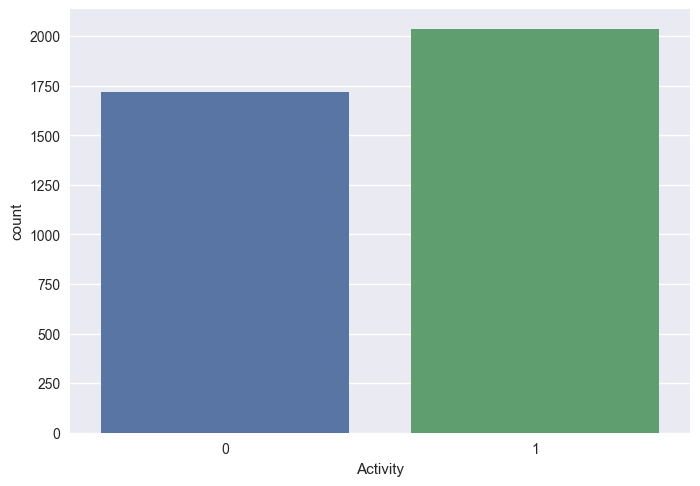

In [113]:
# Проверим данные на сбалансированность классов
sns.countplot(data, x='Activity')

***Вывод***

Данные относительно сбалансированы


### 3 Исследование и проектирование признаков

При выполнении данного проекта в качестве основной цели был указан подобор гиперпараметров для получения наилучшей метрики f1, данные изначально были полностью подготовлены, очищены, нормализованы и закодированы; исследование взаимосвязей между исходными признаками и проектирование новых признаков не проводились

### 4 Подготовка, обучение модели, оптимизация гиперпараметров

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [75]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = RANDOM_SEED, test_size = 0.2)


### <center> **Логистическая регрессия**

#### <center> **Baseline**

Зафиксируем показатель метрики, который был получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию

In [115]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 50)

#Обучаем модель 
score_log = cross_val_score(log_reg, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

print('f1_score на тестовом наборе (baseline): {:.2f}'.format(score_log))

f1_score на тестовом наборе (baseline): 0.77


#### <center> **GridSearchCV**

In [116]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=RANDOM_SEED, 
        max_iter=50 
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

%time 
grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе (GridSearchCV): {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score на тестовом наборе (GridSearchCV): 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}


***Вывод***

Значения метрики f1 увеличилось на 0.01 , т.е. при использовании GridSearchCV с указанными параметрами показатели метрики близки к заданным по умолчанию. 

In [117]:
# Расширим сетку параметров, чтобы попробовать улучшить показатель метрики 

param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=RANDOM_SEED, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time 
grid_search_1.fit(X_train, y_train) 
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе (GridSearchCV): {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score на тестовом наборе (GridSearchCV): 0.79
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


***Вывод***

При расширении сетки параметров нам удалось достигнуть улучшения метрики на 0,02 относительно baseline; при этом значительно был увеличен показатель затраченного времени.

Таким образом, поиск по сетке не гарантирует, что мы найдем наилучшую комбинацию гиперпараметров, так как сетка значений конечна и фактическое наилучшее значение может отсутствовать или оказаться между значений, заданными нами.

#### <center> **RandomizedSearchCV**

In [118]:
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=RANDOM_SEED, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time 
random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе (RandomizedSearchCV): {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score на тестовом наборе (RandomizedSearchCV): 0.78
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}


Изменим набор гиперпараметров с целью улучшения показателя метрики (используем аналогичные параметры для GridSearchCV, которые показали более высокий результат )

In [119]:
param_distributions = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
              
             ]           
random_search_1 = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=RANDOM_SEED, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_1.fit(X_train, y_train) 
y_test_pred = random_search_1.predict(X_test)
print('f1_score на тестовом наборе (RandomizedSearchCV): {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_1.best_params_))

CPU times: total: 844 ms
Wall time: 32.3 s
f1_score на тестовом наборе (RandomizedSearchCV): 0.78
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.5}


***Вывод***

В отличие от GridSearchCV в RandomizedSearchCV не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений (количество комбинаций гиперпараметров задается n_iter). 

В связи с этим временные показатели значительно ниже при практически аналогичных значениях метрики (достигнутый показатель f1 ниже для RandomizedSearchCV в сравнении с лучшим результатом для GridSearchCV на 0.01, но выше, чем для baseline на 0.01)

#### <center> Hyperopt

In [120]:
# зададим пространство поиска гиперпараметров - получится 3 набора, так как для каждого типа регуляции подходят только определённые алгоритмы оптимизации
space_1 = {'penalty': hp.choice(label='penalty', options=['l2', 'none']) , # тип регуляризации
              'solver': hp.choice(label='solver', options=['lbfgs', 'sag']), # алгоритм оптимизации
              'C': hp.uniform('C', 0.01, 10 )
              } # алгоритм оптимизации

space_2 = {'penalty': hp.choice(label='penalty', options=['l1', 'l2']) ,
              'solver': hp.choice(label='solver', options=['liblinear', 'saga']),
              'C': hp.uniform('C', 0.01, 1)
              }

# зафиксируем random_state
random_state = RANDOM_SEED

def hyperopt(space, cv=5, X=X_train, y=y_train, random_state=RANDOM_SEED):

    model=linear_model.LogisticRegression(
    penalty = space['penalty'],
    solver = space['solver'],
    C=np.abs(float(space['C'])),
    random_state=RANDOM_SEED,
    max_iter=50        
    )        
     
    # применим  cross validation 
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


In [121]:
# Подбираем лучшие гиперпараметры для space_1
%time
              
trials = Trials() # используется для логирования результатов  

best_1=fmin(hyperopt, # наша функция 
          space=space_1, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )

print(f'Наилучшие значения гиперпараметров {space_eval(space_1, best_1)}')

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 50/50 [03:25<00:00,  4.11s/trial, best loss: -0.7926833082369134]
Наилучшие значения гиперпараметров {'C': 0.029532999601843312, 'penalty': 0, 'solver': 0}
Наилучшие значения гиперпараметров {'C': 0.029532999601843312, 'penalty': 'l2', 'solver': 'lbfgs'}


In [122]:
# Подбираем лучшие гиперпараметры для space_2
%time
              
trials = Trials() # используется для логирования результатов
  
best_2=fmin(hyperopt, # наша функция 
          space=space_2, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )

print(f'Наилучшие значения гиперпараметров {space_eval(space_2, best_2)}')

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 50/50 [05:05<00:00,  6.11s/trial, best loss: -0.792264081975915] 
Наилучшие значения гиперпараметров {'C': 0.27904611131273815, 'penalty': 0, 'solver': 1}
Наилучшие значения гиперпараметров {'C': 0.27904611131273815, 'penalty': 'l1', 'solver': 'saga'}


Сформируем модели, построенные на лучших значениях гиперпараметров

In [123]:
model_1 = linear_model.LogisticRegression(
        penalty=space_eval(space_1, best_1)['penalty'],
        solver=space_eval(space_1, best_1)['solver'],
        C=float(best_1['C']),
        random_state=RANDOM_SEED,
        max_iter=50)
        
# применим  cross validation 
score_1 = cross_val_score(model_1, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

print('f1_score на тестовом наборе (hyperopt): {:.2f}'.format(score_1))
print("Наилучшие значения гиперпараметров: {}".format(space_eval(space_1, best_1)))


f1_score на тестовом наборе (hyperopt): 0.79
Наилучшие значения гиперпараметров: {'C': 0.029532999601843312, 'penalty': 'l2', 'solver': 'lbfgs'}


In [124]:
model_2 = linear_model.LogisticRegression(
        penalty=space_eval(space_2, best_2)['penalty'],
        solver=space_eval(space_2, best_2)['solver'],
        C=float(best_2['C']),
        random_state=RANDOM_SEED,
        max_iter=50)
        
# применим  cross validation 
score_2 = cross_val_score(model_2, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

print('f1_score на тестовом наборе (hyperopt): {:.2f}'.format(score_2))
print("Наилучшие значения гиперпараметров: {}".format(space_eval(space_2, best_2)))

f1_score на тестовом наборе (hyperopt): 0.79
Наилучшие значения гиперпараметров: {'C': 0.27904611131273815, 'penalty': 'l1', 'solver': 'saga'}


***Вывод***

При использовании метода Hyperopt удалось улучшить метрику по сравнению с baseline. Лучший результат метрики  - 0,79 сопоставим для максимального результата с использованием GridSearchCV

#### <center> Optuna

In [125]:
# Настроим оптимизацию гиперпараметров

def optuna_1(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'newton-cg'])
  C = trial.suggest_float('C', 0.1, 1)  

  # создаем модель
  model=linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C=C, 
        random_state=RANDOM_SEED,
        max_iter=50        
    )   
  # обучаем модель
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

def optuna_2(trial):
  
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', 0.1, 1)  

  # создаем модель
  model=linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C=C, 
        random_state=RANDOM_SEED,
        max_iter=50        
    )   
  # обучаем модель
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [126]:
%time
# Создаем объект исследования для первого набора гиперпараметров
# Можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_1 = optuna.create_study(study_name="LogisticRegression", direction="maximize")

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_1.optimize(optuna_1, n_trials=50)

# Рассчитаем точность для тестовой выборки
model_1 = linear_model.LogisticRegression(**study_1.best_params,random_state=RANDOM_SEED)

# применим  cross validation 
score_log_opt = cross_val_score(model_1, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

print('f1_score на тестовом наборе (optuna): {:.2f}'.format(score_log_opt))
print("Наилучшие значения гиперпараметров: {}".format(study_1.best_params))


[I 2023-03-25 23:43:08,443] A new study created in memory with name: LogisticRegression


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-03-25 23:43:10,451] Trial 0 finished with value: 0.7737791696495413 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.8300673472232951}. Best is trial 0 with value: 0.7737791696495413.
[I 2023-03-25 23:43:12,423] Trial 1 finished with value: 0.7785447225604556 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.21282121505170187}. Best is trial 1 with value: 0.7785447225604556.
[I 2023-03-25 23:44:46,683] Trial 2 finished with value: 0.7214526235329999 and parameters: {'penalty': 'none', 'solver': 'newton-cg', 'C': 0.8836764268789927}. Best is trial 1 with value: 0.7785447225604556.
[I 2023-03-25 23:44:51,985] Trial 3 finished with value: 0.7757525816757611 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.660745209942198}. Best is trial 1 with value: 0.7785447225604556.
[I 2023-03-25 23:46:26,941] Trial 4 finished with value: 0.7214526235329999 and parameters: {'penalty': 'none', 'solver': 'newton-cg', 'C': 0.2884557919931058}. Best is trial 1 with 

f1_score на тестовом наборе (optuna): 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.10488951840793292}


In [127]:
%time
# Создаем объект исследования для второго набора гиперпараметров
# Можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_2 = optuna.create_study(study_name="LogisticRegression", direction="maximize")

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_2.optimize(optuna_2, n_trials=50)

# рассчитаем точность для тестовой выборки
model_2 = linear_model.LogisticRegression(**study_2.best_params,random_state=RANDOM_SEED)

# применим  cross validation 
score_log_opt_2 = cross_val_score(model_2, X, y, cv=5, scoring="f1", n_jobs=-1).mean()


print('f1_score на тестовом наборе (optuna): {:.2f}'.format(score_log_opt_2))
print("Наилучшие значения гиперпараметров: {}".format(study_2.best_params))

[I 2023-03-25 23:54:26,060] A new study created in memory with name: LogisticRegression


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-03-25 23:54:32,287] Trial 0 finished with value: 0.7783984299909938 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.976791336566118}. Best is trial 0 with value: 0.7783984299909938.
[I 2023-03-25 23:54:42,473] Trial 1 finished with value: 0.7855875196694022 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.7772021344146531}. Best is trial 1 with value: 0.7855875196694022.
[I 2023-03-25 23:54:51,797] Trial 2 finished with value: 0.7876591034115655 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.49003020831820476}. Best is trial 2 with value: 0.7876591034115655.
[I 2023-03-25 23:55:02,682] Trial 3 finished with value: 0.7881475984981079 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.5029076834376138}. Best is trial 3 with value: 0.7881475984981079.
[I 2023-03-25 23:55:11,108] Trial 4 finished with value: 0.7872942463224916 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.19058163242586018}. Best is trial 3 with value: 0.7881475

f1_score на тестовом наборе (optuna): 0.79
Наилучшие значения гиперпараметров: {'penalty': 'l1', 'solver': 'saga', 'C': 0.42850233969583834}


***Вывод***

Полученные значения метрики f1 с применением optuna: наилучший показатель - 0.79 выше в сравнении с baseline (сопоставим для максимальных значений метрики при использовании GridSearchCV, Hyperopt)

In [106]:
#Построим графики визуализации для второго набора гиперпараметров

# история оптимизации
optuna.visualization.plot_optimization_history(study_2, target_name="f1_score")

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет (в данном случае наблюдаем увеличение значений метрики)

In [128]:
# график важности гиперпараметров
optuna.visualization.plot_param_importances(study_2, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить значительное внимание на настройку гиперпараметра "penalty"

### <center> **Random Forest**

#### <center> **Baseline**

Зафиксируем показатель метрики, который был получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию

In [129]:
#Создаем объект
random_reg = ensemble.RandomForestClassifier(random_state=RANDOM_SEED)

# Обучаем модель
score_reg = cross_val_score(random_reg, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

# выводим метрики
print('f1_score на тестовом наборе (baseline): {:.2f}'.format(score_reg))

f1_score на тестовом наборе (baseline): 0.81


***Вывод***

Полученное значение метрики (baseline) для алгоритма RandomForest значительно превышает аналогичный показатель для LogisticRegression, что свидетельствует о большей эффективности алгоритма RandomForest в данном случае

#### <center> **GridSearchCV**

In [130]:
%time
# задаём сетку параметров
param_grid_for = {'n_estimators': list(range(50, 200, 30)), # количество деревьев в лесу
              'min_samples_leaf': list(range(1, 6, 1)), # минимальное число объектов в листе
              'max_depth': list(np.linspace(10, 40, 5, dtype=int)), # максимальная глубина одного дерева
              'criterion': ['gini', 'entropy'] # критерий информативности разбиения для каждого из деревьев
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RANDOM_SEED), 
    param_grid=param_grid_for, 
    cv=5, 
    n_jobs = -1,
)  
 
grid_search_forest.fit(X_train, y_train)
y_test_pred = grid_search_forest.predict(X_test)

print('f1_score на тестовом наборе (GridSearchCV): {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
f1_score на тестовом наборе (GridSearchCV): 0.81
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 1, 'n_estimators': 170}


***Вывод***

Полученный результат метрики при использовании GridSearchCV идентичен для показателей baseline данного алгоритма, при этом временные затраты значительно выше 

#### <center> **RandomizedSearchCV**

In [131]:
param_random_for = {'n_estimators': list(range(50, 200, 30)), # количество деревьев в лесу
              'min_samples_leaf': list(range(1, 6, 1)),
              'max_depth': list(np.linspace(10, 40, 5, dtype=int)), # максимальная глубина одного дерева
              'criterion': ['gini', 'entropy'] # критерий информативности разбиения для каждого из деревьев
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RANDOM_SEED), 
    param_distributions=param_random_for, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1,
    
)  
random_search_forest.fit(X_train, y_train) 
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе (RandomizedSearchCV): {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))


f1_score на тестовом наборе (RandomizedSearchCV): 0.81
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 1, 'max_depth': 17, 'criterion': 'gini'}


***Вывод***

Полученный результат метрики при использовании RandomizedSearchCV идентичен для показателей baseline и GridSearchCV данного алгоритма, при этом временные затраты значительно ниже в сравнении с GridSearchCV

#### <center> Hyperopt

In [132]:
space = {'n_estimators': hp.quniform('n_estimators', 50, 200, 30), # количество деревьев в лесу
              'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 6, 1),
              'max_depth': hp.quniform('max_depth', 10, 40, 5), # максимальная глубина одного дерева
              'criterion': hp.choice(label='criterion', options=['gini', 'entropy']) # критерий информативности разбиения для каждого из деревьев
              }

# зафиксируем random_state
random_state = RANDOM_SEED

def hyperopt_rf(params, cv=5, X=X, y=y, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf']),
             'criterion': params['criterion']
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=RANDOM_SEED)

    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [133]:
%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best_rf=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )

print(f'Наилучшие значения гиперпараметров {space_eval(space, best_rf)}')


CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 50/50 [03:55<00:00,  4.71s/trial, best loss: -0.8163616323519728]
Наилучшие значения гиперпараметров (hyperopt) {'criterion': 1, 'max_depth': 40.0, 'min_samples_leaf': 2.0, 'n_estimators': 120.0}
Наилучшие значения гиперпараметров {'criterion': 'entropy', 'max_depth': 40.0, 'min_samples_leaf': 2.0, 'n_estimators': 120.0}


In [134]:
# рассчитаем точность для тестовой выборки
model_rf = ensemble.RandomForestClassifier(
    random_state=RANDOM_SEED, 
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf']),
    criterion= space_eval(space, best_rf)['criterion']    
)

score_rf = cross_val_score(model_rf, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

print('f1_score на тестовом наборе (hyperopt): {:.2f}'.format(score_rf))
print("Наилучшие значения гиперпараметров: {}".format(space_eval(space, best_rf)))


f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 40.0, 'min_samples_leaf': 2.0, 'n_estimators': 120.0}


***Вывод***

При использовании hyperopt нам удалось достичь увеличения метрики на 0.01 в сравнении с ранее достигнутыми для алгоритма RandomForestClassifier

#### <center> Optuna

In [137]:
def optuna_rf(trial):
  
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 200, 30)
  max_depth = trial.suggest_int('max_depth', 10, 40, 5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6, 1)
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=RANDOM_SEED,
                                          criterion=criterion)
  
  # обучаем модель cross validation 
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [138]:
%time
# Создаем объект исследования
# Можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=RANDOM_SEED)

# применим  cross validation 

score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

print('f1_score на тестовом наборе (optuna): {:.2f}'.format(score))
print("Наилучшие значения гиперпараметров: {}".format(study.best_params))


[I 2023-03-26 01:02:03,879] A new study created in memory with name: RandomForestClassifier
[W 2023-03-26 01:02:03,883] Trial 0 failed with parameters: {'n_estimators': 170, 'max_depth': 10, 'min_samples_leaf': 6, 'criterion': 'gini'} because of the following error: TypeError("__init__() got an unexpected keyword argument 'max_iter'").
Traceback (most recent call last):
  File "c:\Users\Misha\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Misha\AppData\Local\Temp\ipykernel_16440\3703276220.py", line 10, in optuna_rf
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
TypeError: __init__() got an unexpected keyword argument 'max_iter'
[W 2023-03-26 01:02:04,000] Trial 0 failed with value None.


CPU times: total: 0 ns
Wall time: 0 ns


TypeError: __init__() got an unexpected keyword argument 'max_iter'

***Вывод***

При использовании optuna нам удалось также достичь метрики 0.82, что аналогично результатам применения hyperopt.

In [105]:
#Построим графики визуализации гиперпараметров

# история оптимизации
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [104]:
# график важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра "max_depth".

***Общий вывод***

Для решения данной задачи классификации были обучены две модели - логистической регрессии и модель случайного леса по параметрам, установленным по умолчанию (baseline), а также были подобраны гиперпараметры моделей предложенными методами - GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna.

Все рассмотренные методы позволили улучшить метрику в сравнении с базовой моделью, но полученный прирост метрики при использовании каждого из методов в сравнении с baseline не значителен, что свидетельствует о том, что настройки по умолчанию подобраны оптимальным образом.

Наилучший результат по метрике f1 - при использовании алгоритма RandomForestClassifier с подобранными параметрами методов Hyperopt, Optuna